# "COVID-19 Vaccine Tweet Sentiment Analysis with fastai - Part 1"
> "This is part one of a two part NLP series where we will carry out sentiment analysis on COVID-19 vaccine tweets. In this part we will follow the ULMFiT approach with fastai to create a twitter language model, then use this to fine-tune a tweet sentiment classification model."

- toc: true
- branch: master
- badges: true
- comments: true
- author: Tom Whelan
- categories: [fastai, NLP, sentiment analysis, PyTorch]
- image: images/twitter-sentiment-analysis.jpg

# Introduction
In this post we will create a model to perform sentiment analysis on tweets about COVID-19 vaccines using the [`fastai`](https://docs.fast.ai/) library. I will provide a brief overview of the process here, but a much more in-depth explanation of NLP with [`fastai`](https://docs.fast.ai/) can be found in [lesson 8](https://course.fast.ai/videos/?lesson=8) of the [`fastai`](https://docs.fast.ai/) course. For convenience clicking on inline code written like [`this`](https://docs.fast.ai/tutorial.text.html) will take you to the relevant part of the [`fastai`](https://docs.fast.ai/) documentation where appropriate. In part 2 we will use the model for analysis, looking at changes in tweet sentiment over time and how that relates to the progress of vaccination in different countries.

# Transfer learning in NLP - the ULMFiT approach

We will be making use of *transfer learning* to help us create a model to analyse tweet sentiment. The idea behind transfer learning is that neural networks learn information that generalises to new problems, [particularly the early layers of the network](https://arxiv.org/pdf/1311.2901.pdf). In computer vision, for example, we can take a model that was trained on the ImageNet dataset to recognise different features of images such as circles, then apply that to a smaller dataset and *fine-tune* the model to be more suited to a specific task (e.g. classifying images as cats or dogs). This technique allows us to train neural networks much faster and with far less data than we would otherwise need.

In 2018 [a paper](https://arxiv.org/abs/1801.06146) introduced a transfer learning technique for NLP called 'Universal Language Model Fine-Tuning' (ULMFiT). The approach is as follows:
1. Train a *language model* to predict the next word in a sentence. This step is already done for us; with [`fastai`](https://docs.fast.ai/) we can download a model that has been pre-trained for this task on millions of Wikipedia articles. A good language model already knows a lot about how language works in general - for  instance, given the sentence 'Tokyo is the capital of', the model might predict 'Japan' as the next word. In this case the model understands that Tokyo is closely related to Japan and that 'capital' refers to 'city' here instead of 'upper-case' or 'money'.
2. Fine-tune the language model to a more specific task. The pre-trained language model is good at understanding Wikipedia English, but Twitter English is a bit different. We can take the information the Wikipedia model has learned and apply that to a Twitter dataset to get a Twitter language model that is good at predicting the next word in a tweet.
3. Fine-tune a *classification model* to identify sentiment using the pre-trained language model. The idea here is that since our language model already knows a lot about Twitter English, it's not a huge leap from there to train a classifier that understands that 'love' refers to positive sentiment and 'hate' refers to negative sentiment. If we tried to train a classifier without using a pre-trained model it would have to learn the whole language from scratch first, which would be very difficult and time consuming.

![](https://github.com/twhelan22/blog/blob/master/images/ulmfit_process.png?raw=true "Credit: https://course.fast.ai/")

This notebook will walk through steps 2 and 3 with [`fastai`](https://docs.fast.ai/). We will then apply the model to unlabelled COVID-19 vaccine tweets and save the results for analysis in part 2.

> Important: You will need a GPU to train models with [`fastai`](https://course.fast.ai/start_colab), but fortunately for us Google Colab provides us with access to one for free! To use it, select 'Runtime' from the menu at the top of the notebook, then 'Change runtime type', and ensure your hardware accelerator is set to 'GPU' before continuing!

# Data preparation
This is a write-up of a submission I made for several [Kaggle tasks](https://www.kaggle.com/gpreda/all-covid19-vaccines-tweets/tasks). The tasks are still open and accepting new entries at the time of writing if you want to enter as well! On Kaggle the data is already readily available when using their notebook servers; however, we are using Google Colab today, so we will need to access the [Kaggle API](https://www.kaggle.com/docs/api) to download the data.
> Note: Kaggle also have free GPU credits if you prefer to work on their notebook servers instead.

## Getting the data from Kaggle
The first step is to create an API token. To do this, the steps are as follows:


1.   Go to 'Account' on Kaggle and scroll down to the 'API' section.
2.   Expire all current API tokens by clicking 'Expire API Token'.
3.   Click 'Create New API Token', which will automatically download a file called `kaggle.json`.
4.   Upload the `kaggle.json` file using the file uploader widget below.



In [1]:
# See https://neptune.ai/blog/google-colab-dealing-with-files for more tips on working with files in Colab
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


Next, we need to install the Kaggle API.
> Note: The API is already preinstalled in Google Colab, but sometimes it's an outdated version, so it's best to upgrade it in case.

In [2]:
!pip uninstall -q -y kaggle
!pip install -q --upgrade pip
!pip install -q --upgrade kaggle

     |████████████████████████████████| 1.5MB 16.2MB/s 
     |████████████████████████████████| 58 kB 5.3 MB/s 


The [API docs](https://github.com/Kaggle/kaggle-api) tell us that we need to ensure `kaggle.json` is in the location `~/.kaggle/kaggle.json`, so let's make the directory and move the file.

In [3]:
# https://www.machinelearningmindset.com/kaggle-dataset-in-google-colab/
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Check the file in its new directory
!ls /root/.kaggle/
# Check the file permission
!ls -l ~/.kaggle/kaggle.json
#Change the file permission
# chmod 600 file – owner can read and write
# chmod 700 file – owner can read, write and execute
!chmod 600 ~/.kaggle/kaggle.json

kaggle.json
-rw-r--r-- 1 root root 63 Mar 17 14:33 /root/.kaggle/kaggle.json


Now we can download the data using `!kaggle dataset download -d username-of-dataset-creator/name-of-dataset`.
> Note: There is also an API download command on the dataset page that you can copy/paste instead.

In [4]:
# We will be using two datasets for this part, as well as a third dataset for part 2
# To save time in part 2 I'm going to download them all now and save locally
!kaggle datasets download -d gpreda/all-covid19-vaccines-tweets
!kaggle datasets download -d maxjon/complete-tweet-sentiment-extraction-data
!kaggle datasets download -d gpreda/covid-world-vaccination-progress

100% 4.76M/4.76M [00:00<00:00, 14.9MB/s]
100% 4.76M/4.76M [00:00<00:00, 14.9MB/s]
  0% 0.00/2.58M [00:00<?, ?B/s]
100% 2.58M/2.58M [00:00<00:00, 197MB/s]
  0% 0.00/146k [00:00<?, ?B/s]
100% 146k/146k [00:00<00:00, 55.6MB/s]


The files will be downloaded in `.zip` format, so let's unzip them.

In [5]:
# To unzip you can use the following:
#!mkdir folder_name
#!unzip anyfile.zip -d folder_name

# Or unzip all
!unzip -q \*.zip


3 archives were successfully processed.


## Loading and cleaning the data
As with `kaggle`, an older version of [`fastai`](https://docs.fast.ai/) is preinstalled in Colab, so we will need to upgrade it first.

> Important: Make a note of the [`fastai`](https://docs.fast.ai/) version you are using, since any models you create and save will need to be run using the same version later.

In [6]:
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab
import fastai; fastai.__version__

     |████████████████████████████████| 193 kB 14.3 MB/s 
     |████████████████████████████████| 776.8 MB 16 kB/s 
     |████████████████████████████████| 12.8 MB 72.1 MB/s 
     |████████████████████████████████| 53 kB 1.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.9.0 requires torch==1.8.0, but you have torch 1.7.1 which is incompatible.


'2.2.7'

Let's import [`fastai`](https://docs.fast.ai/)'s [`text`](https://docs.fast.ai/tutorial.text.html) module and take a look at our data.
> Tip: If you use `import *`, useful libraries like `pandas` and `numpy` will also be imported at the same time!

In [7]:
from fastai.text.all import *

In [8]:
vax_tweets = pd.read_csv('vaccination_all_tweets.csv')
vax_tweets.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA","Aggregator of Asian American news; scanning diverse sources 24/7/365. RT's, Follows and 'Likes' will fuel me 👩‍💻",2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s music junkie. Fascinated by meteorology and all things in the cloud. Opinions are my own.",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,"While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlCHrZjkhm",NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P,"['coronavirus', 'SputnikV', 'AstraZeneca', 'PfizerBioNTech', 'Moderna', 'Covid_19']",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radio Network. Weeknights 7 Pacific-10 Eastern - Email comments/ideas to charles@charlesadlertonight.ca",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're not ethically sturdy enough to acknowledge them. (1) You were born i… https://t.co/jqgV18kch4",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternative news source from citizen journalists that haven't sold out. Real news & real views,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @BorisJohnson @MattHancock #whereareallthesickpeople #PfizerBioNTech… https://t.co/KxbSRoBEHq,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


We could use the `text` column of this dataset to train a Twitter language model, but since our end goal is sentiment analysis we will need to find another dataset that also contains sentiment labels to train our classifier. Let's use ['Complete Tweet Sentiment Extraction Data'](https://www.kaggle.com/maxjon/complete-tweet-sentiment-extraction-data), which contains 40,000 tweets labelled as either negative, neutral or positive sentiment. For more accurate results you could use the ['sentiment140'](https://www.kaggle.com/kazanova/sentiment140) dataset instead, which contains 1.6m tweets labelled as either positive or negative.

In [9]:
tweets = pd.read_csv('tweet_dataset.csv')
tweets.head()

,textID,sentiment,author,text,old_text,aux_id,new_sentiment,selected_text
0,1956967341,empty,xoshayzers,i know i was listenin to bad habit earlier and i started freakin at his part =[,@tiffanylue i know i was listenin to bad habit earlier and i started freakin at his part =[,p1000000000,NaN,NaN
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin on your call...,Layin n bed with a headache ughhhh...waitin on your call...,c811396dc2,negative,headache
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...,Funeral ceremony...gloomy friday...,9063631ab1,negative,gloomy
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!,wants to hang out with friends SOON!,2a815f151d,positive,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,"We want to trade with someone who has Houston tickets, but no one will.","@dannycastillo We want to trade with someone who has Houston tickets, but no one will.",82565a56d3,neutral,"We want to trade with someone who has Houston tickets, but no one will."


For our language model, the only input we need is the tweet text. As we will see in a moment [`fastai`](https://docs.fast.ai/) can handle text preprocessing and tokenization for us, but it might be a good idea to remove things like twitter handles, urls, hashtags and emojis first. You could experiment with leaving these in for your own models and see how it affects the results. There are also some rows with blank tweets which need to be removed.

We ideally want the language model to learn not just about tweet language, but more specifically about vaccine tweet language. We can therefore use text from both datasets as input for the language model. For the classification model we need to remove all rows with missing sentiment, however.

In [10]:
#collapse-hide
# Code via https://www.kaggle.com/garyongguanjie/comments-analysis
def de_emojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

# Code via https://www.kaggle.com/pawanbhandarkar/generate-smarter-word-clouds-with-log-likelihood
def tweet_proc(df, text_col='text'):
    df['orig_text'] = df[text_col]
    # Remove twitter handles
    df[text_col] = df[text_col].apply(lambda x:re.sub('@[^\s]+','',x))
    # Remove URLs
    df[text_col] = df[text_col].apply(lambda x:re.sub(r"http\S+", "", x))
    # Remove emojis
    df[text_col] = df[text_col].apply(de_emojify)
    # Remove hashtags
    df[text_col] = df[text_col].apply(lambda x:re.sub(r'\B#\S+','',x))
    return df[df[text_col]!='']

# Clean the text data and combine the dfs
tweets = tweets[['old_text', 'new_sentiment']].rename(columns={'old_text':'text', 'new_sentiment':'sentiment'})
vax_tweets['sentiment'] = np.nan
tweets = tweet_proc(tweets)
vax_tweets = tweet_proc(vax_tweets)
df_lm = tweets[['text', 'sentiment']].append(vax_tweets[['text', 'sentiment']])
df_clas = df_lm.dropna(subset=['sentiment'])
print(len(df_lm), len(df_clas))

70732 31323


In [11]:
df_clas.head()

,text,sentiment
1,Layin n bed with a headache ughhhh...waitin on your call...,negative
2,Funeral ceremony...gloomy friday...,negative
3,wants to hang out with friends SOON!,positive
4,"We want to trade with someone who has Houston tickets, but no one will.",neutral
5,Re-pinging why didn't you go to prom? BC my bf didn't like my friends,negative


# Training a language model
To train our language model we can use self-supervised learning; we just need to give the model some text as an independent variable and [`fastai`](https://docs.fast.ai/) will automatically preprocess it and create a dependent variable for us. We can do this in one line of code using the [`DataLoaders`](https://docs.fast.ai/data.core.html#DataLoaders) class, which converts our input data into a [`DataLoader`](https://docs.fast.ai/data.load.html#DataLoader) object that can be used as an input to a [`fastai`](https://docs.fast.ai/) [`Learner`](https://docs.fast.ai/learner.html#Learner).

In [12]:
dls_lm = TextDataLoaders.from_df(df_lm, text_col='text', is_lm=True, valid_pct=0.1)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Here we told [`fastai`](https://docs.fast.ai/) that we are working with text data, which is contained in the `text` column of a [`pandas`](https://pandas.pydata.org/docs/) [`DataFrame`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) called `df_lm`. We set [`is_lm=True`](https://docs.fast.ai/text.data.html#TextDataLoaders) since we want to train a language model, so [`fastai`](https://docs.fast.ai/) needs to label the input data for us. Finally, we told [`fastai`](https://docs.fast.ai/) to hold out a random 10% of our data for a validation set using [`valid_pct=0.1`](https://docs.fast.ai/text.data.html#TextDataLoaders).

Let's take a look at the first two rows of the [`DataLoader`](https://docs.fast.ai/data.load.html#DataLoader) using [`show_batch`](https://docs.fast.ai/data.core.html#TfmdDL.show_batch).

In [13]:
dls_lm.show_batch(max_n=2)

,text,text_
0,"xxbos for … the … loss . xxunk … him , not u. what u up to on the wknd ? i wanna s xxrep 7 e ya ! xxbos xxup uk \n▁ queue at a xxbos xxmaj could nt agree more well put xxmaj xxunk xxbos xxmaj he is a xxunk liar have enough . just did nt order enough . xxmaj probably beca xxbos xxmaj wow … \n\n xxmaj xxunk","for … the … loss . xxunk … him , not u. what u up to on the wknd ? i wanna s xxrep 7 e ya ! xxbos xxup uk \n▁ queue at a xxbos xxmaj could nt agree more well put xxmaj xxunk xxbos xxmaj he is a xxunk liar have enough . just did nt order enough . xxmaj probably beca xxbos xxmaj wow … \n\n xxmaj xxunk !"
1,xxmaj everybody please go get vaccinated when you are eligible xxbos xxmaj welcoming xxunk xxmaj i 'm so proud ! xxbos xxmaj most medicines have a list of xxup xxunk side effects . \n xxmaj that is why you should xxup not take anything you do not need too xxbos is offering gives us the schedule which includes xxbos xxmaj canada politicizing xxmaj the ' virus ' is not causing economic business,everybody please go get vaccinated when you are eligible xxbos xxmaj welcoming xxunk xxmaj i 'm so proud ! xxbos xxmaj most medicines have a list of xxup xxunk side effects . \n xxmaj that is why you should xxup not take anything you do not need too xxbos is offering gives us the schedule which includes xxbos xxmaj canada politicizing xxmaj the ' virus ' is not causing economic business collapse


We have a new column, `text_`, which is `text` offset by one. This is the dependent variable [`fastai`](https://docs.fast.ai/) created for us. By default [`fastai`](https://docs.fast.ai/) uses *word tokenization*, which splits the text on spaces and punctuation marks and breaks up words like *can't* into two separate tokens. [`fastai`](https://docs.fast.ai/) also has some special tokens starting with 'xx' that are designed to make things easier for the model; for example [`xxmaj`](https://docs.fast.ai/text.data.html) indicates that the next word begins with a capital letter and [`xxunk`](https://docs.fast.ai/text.data.html) represents an unknown word that doesn't appear in the vocabulary very often. You could experiment with *subword tokenization* instead, which will split the text on commonly occuring groups of letters instead of spaces. This might help if you wanted to leave hashtags in since they often contain multiple words joined together with no spaces, e.g. #CovidVaccine. The [`fastai`](https://docs.fast.ai/) tokenization process is explained in much more detail [here](https://youtu.be/WjnwWeGjZcM?t=626) for those interested.

## Fine-tuning the language model
The next step is to create a language model using [`language_model_learner`](https://docs.fast.ai/text.learner.html#language_model_learner).

In [14]:
learn = language_model_learner(dls_lm, AWD_LSTM, drop_mult=0.3, metrics=[accuracy, Perplexity()]).to_fp16()

Here we passed [`language_model_learner`](https://docs.fast.ai/text.learner.html#language_model_learner) our [`DataLoaders`](https://docs.fast.ai/data.core.html#DataLoaders), `dls_lm`, and the pre-trained [RNN](https://www.simplilearn.com/tutorials/deep-learning-tutorial/rnn) model, [*AWD_LSTM*](https://docs.fast.ai/text.models.awdlstm.html), which is built into [`fastai`](https://docs.fast.ai/). [`drop_mult`](https://docs.fast.ai/text.learner.html#text_classifier_learner) is a multiplier applied to all [dropouts](https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/) in the AWD_LSTM model to reduce overfitting. For example, by default [`fastai`](https://docs.fast.ai/)'s AWD_LSTM applies [`EmbeddingDropout`](https://docs.fast.ai/text.models.awdlstm.html#EmbeddingDropout) with 10% probability (at the time of writing), but we told [`fastai`](https://docs.fast.ai/) that we want to reduce that to 3%. The [`metrics`](https://docs.fast.ai/metrics.html) we want to track are *perplexity*, which is the exponential of the loss (in this case cross entropy loss), and *accuracy*, which tells us how often our model predicts the next word correctly. We can also train with fp16 to use less memory and speed up the training process.

We can find a good learning rate for training using [`lr_find`](https://docs.fast.ai/callback.schedule.html#Learner.lr_find) and use that to fit our model.

SuggestedLRs(lr_min=0.04365158379077912, lr_steep=0.04786301031708717)

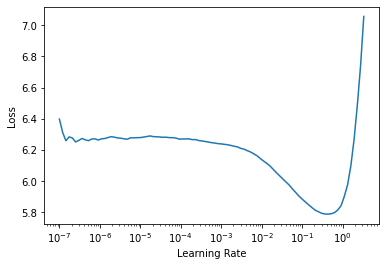

In [15]:
learn.lr_find()

When we created our [`Learner`](https://docs.fast.ai/learner.html#Learner) the embeddings from the pre-trained AWD_LSTM model were merged with random embeddings added for words that weren't in the vocabulary. The pre-trained layers were also automatically frozen for us. Using [`fit_one_cycle`](https://docs.fast.ai/callback.schedule.html#Learner.fit_one_cycle) with our [`Learner`](https://docs.fast.ai/learner.html#Learner) will train only the *new random embeddings* (i.e. words that are in our Twitter vocab but not the Wikipedia vocab) in the last layer of the neural network.

In [16]:
learn.fit_one_cycle(1, 3e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.380641,4.271222,0.255222,71.609062,01:22


After one epoch our language model is predicting the next word in a tweet around 25% of the time - not too bad! We can [`unfreeze`](https://docs.fast.ai/learner.html#Learner.unfreeze) the entire model, find a more suitable learning rate and train for a few more epochs to improve the accuracy further.

SuggestedLRs(lr_min=0.00036307806149125097, lr_steep=1.5848931980144698e-06)

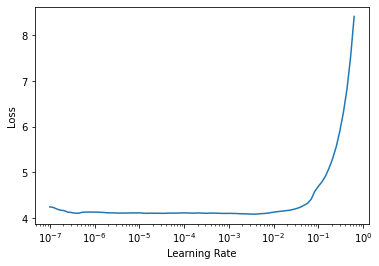

In [17]:
learn.unfreeze()
learn.lr_find()

In [18]:
learn.fit_one_cycle(4, 1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.966653,4.109181,0.277485,60.896847,01:29
1,3.821457,4.034442,0.288567,56.511375,01:29
2,3.608506,4.026432,0.292612,56.060532,01:29
3,3.472149,4.053843,0.292037,57.618488,01:28


After a bit more training we can predict the next word in a tweet around 29% of the time. Let's test the model out by using it to write some random tweets (in this case it will generate some text following 'I love').

In [19]:
# Text generation using the language model
TEXT = "I love"
N_WORDS = 30
N_SENTENCES = 2
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

i love all the stuff i want to do … That 's the reason we do n't have to go to Ireland … i hope it works :
i love how much i love the Johnson ! Fever is I 'm a horrible motivation . Twenty thousand people ( among the first ) received the


Let's save the model *encoder* so we can use it to fine-tune our classifier. The encoder is all of the model except for the final layer, which converts activations to probabilities of picking each token in the vocabulary. We want to keep the knowledge the model has learned about tweet language but we won't be using our classifier to predict the next word in a sentence, so we won't need the final layer any more.

In [20]:
learn.save_encoder('finetuned_lm')

# Training a sentiment classifier
To get the [`DataLoaders`](https://docs.fast.ai/data.core.html#DataLoaders) for our classifier let's use the [`DataBlock`](https://docs.fast.ai/tutorial.datablock.html#Text) API this time, which is more customisable.

In [21]:
dls_clas = DataBlock(
    blocks = (TextBlock.from_df('text', seq_len=dls_lm.seq_len, vocab=dls_lm.vocab), CategoryBlock),
    get_x=ColReader('text'),
    get_y=ColReader('sentiment'),
    splitter=RandomSplitter()
).dataloaders(df_clas, bs=64)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


To use the API, [`fastai`](https://docs.fast.ai/) needs the following:
* [`blocks`](https://docs.fast.ai/data.block.html#TransformBlock):
    * [`TextBlock`](https://docs.fast.ai/text.data.html#TextBlock): Our x variable will be text contained in a [`pandas`](https://pandas.pydata.org/docs/) [`DataFrame`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html). We want to use the same sequence length and vocab as the language model [`DataLoaders`](https://docs.fast.ai/data.core.html#DataLoaders) so we can make use of our pre-trained model.
    * [`CategoryBlock`](https://docs.fast.ai/data.block.html#CategoryBlock): Our y variable will be a single-label category (negative, neutral or positive sentiment).
* [`get_x`](https://docs.fast.ai/data.transforms.html#ColReader), [`get_y`](https://docs.fast.ai/data.transforms.html#ColReader): Get data for the model by reading the `text` and `sentiment` columns from the [`DataFrame`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html).
* [`splitter`](https://docs.fast.ai/data.transforms.html#RandomSplitter): We will use [`RandomSplitter()`](https://docs.fast.ai/data.transforms.html#RandomSplitter) to randomly split the data into a training set (80% by default) and a validation set (20%).
* [`dataloaders`](https://docs.fast.ai/data.block#DataBlock.dataloaders): Builds the [`DataLoaders`](https://docs.fast.ai/data.core.html#DataLoaders) using the [`DataBlock`](https://docs.fast.ai/tutorial.datablock.html#Text) template we just defined, the *df_clas* [`DataFrame`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) and a batch size of 64.

We can call show batch as before; this time the dependent variable is sentiment.

In [22]:
dls_clas.show_batch(max_n=2)

,text,category
0,xxbos xxup pirate xxup voice : xxrep 3 a xxrep 3 r xxrep 3 g xxrep 3 h xxrep 3 ! i 4got xxup my xxup damn xxup wallet xxup at xxup work xxup xxunk xxrep 3 ! xxup dammit xxrep 3 ! xxup so xxup close xxup yet xxup so xxup far xxrep 3 ! xxup now xxup i m xxup starving xxrep 3 !,negative
1,"xxbos xxup mandy xxrep 3 ! xxup it xxup wo n't xxup let xxup me xxup vote i xxup want xxup her xxup to xxup win xxup but i xxup ca n't xxup help , i xxup am xxup gon na xxup jump xxup off a xxup bridge ( kidding ) xxup but xxup this xxup sux",neutral


Initialising the [`Learner`](https://docs.fast.ai/learner.html#Learner) is similar to before, but in this case we want a [`text_classifier_learner`](https://docs.fast.ai/text.learner.html#text_classifier_learner).

In [23]:
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, metrics=accuracy).to_fp16()

Finally, we want to load the encoder from the language model we trained earlier, so our classifier uses pre-trained weights.

In [24]:
learn = learn.load_encoder('finetuned_lm')

## Fine-tuning the classifier
Now we can train the classifier using *discriminative learning rates* and *gradual unfreezing*, which has been found to give better results for this type of model. First let's freeze all but the last layer:

In [25]:
learn.fit_one_cycle(1, 3e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.844210,0.779984,0.638729,00:34


Now freeze all but the last two layers:

In [26]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.721439,0.652761,0.722063,00:35


Now all but the last three:

In [27]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.645988,0.604143,0.746807,00:37


Finally, let's unfreeze the entire model and train a bit more:

In [28]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.574464,0.594402,0.753193,00:38
1,0.563834,0.597232,0.758301,00:38
2,0.514356,0.598695,0.757982,00:38


In [29]:
learn.save('classifier')

Path('models/classifier.pth')

Our model correctly predicts sentiment around 75% of the time. We could perhaps do better with a larger dataset as mentioned earlier, or different model hyperparameters. It might be worth experimenting with this yourself to see if you can improve the accuracy.

We can quickly sense check the model by calling [`predict`](https://docs.fast.ai/learner.html#Learner.predict), which returns the predicted sentiment, the index of the prediction and predicted probabilities for negative, neutral and positive sentiment.

In [30]:
learn.predict("I love")

('positive', tensor(2), tensor([4.6136e-04, 1.1758e-03, 9.9836e-01]))

In [31]:
learn.predict("I hate")

('negative', tensor(0), tensor([0.9815, 0.0145, 0.0040]))

# Classifying unlabelled tweets
To carry out sentiment analysis on the vaccine tweets, we can add them to the [`DataLoaders`](https://docs.fast.ai/data.core.html#DataLoaders) as a test set:

In [32]:
pred_dl = dls_clas.test_dl(vax_tweets['text'])

We can then make predictions using [`get_preds`](https://docs.fast.ai/learner.html#Learner.get_preds):

In [33]:
preds = learn.get_preds(dl=pred_dl)

Finally, we can save the results for analysis later.

In [34]:
# Get predicted sentiment
vax_tweets['sentiment'] = preds[0].argmax(dim=-1)
vax_tweets['sentiment'] = vax_tweets['sentiment'].map({0:'negative', 1:'neutral', 2:'positive'})

# Convert dates
vax_tweets['date'] = pd.to_datetime(vax_tweets['date'], errors='coerce').dt.date

# Save to csv
vax_tweets.to_csv('vax_tweets_inc_sentiment.csv')

# Conclusion
`fastai` make NLP really easy, and we were able to get quite good results with a limited dataset and not a lot of training time by using the ULMFiT approach. To summarise, the steps are:
1. Fine-tune a language model to predict the next word in a tweet, using a model pre-trained on Wikipedia.
2. Fine-tune a classification model to predict tweet sentiment using the pre-trained language model.
3. Apply the classifier to unlabelled tweets to analyse sentiment.

In part 2 we will use our new model for analysis, investigating the overall sentiment of each vaccine, how sentiment changes over time and the relationship between sentiment and vaccination progress in different countries.

I hope you found this useful, and thanks very much to [Gabriel Preda](https://www.kaggle.com/gpreda) for providing the data!